## Introduction

In this notebook we will use the Tensorflow Recommenders (TFRS) library to build a recommendation system. TFRS is a library for building deep learning recommendation systems. It helps with the full workflow of building a recommendation system: data preparation, model formulation, training, evaluation, and deployment. TFRS is built on top of TensorFlow 2 and Keras, and is designed to be scalable and easy to use.

We are first focusing on a retrieval system, which is a model that predicts a set of movies from the catalogue that the user is likely to watch. We're going to treat the dataset as an implicit system. This means that we are not trying to predict the rating that a user will give to a movie. Instead, we are trying to rank movies by their relevance to the user. This is a common scenario in many recommendation systems, where we are trying to predict the items that a user is most likely to interact with.
Treating Movielens as an implicit system means that we're interpreting users' actions (watching movies) as indicators of their preferences. Specifically:

1. Every movie a user has watched is considered a positive example, indicating that they like or are interested in that movie.
2. Every movie a user hasn't watched is treated as an implicit negative example, implying that they haven't shown interest in it or haven't been exposed to it yet.

This approach helps us make predictions about which movies users might enjoy based on their past behavior without requiring explicit feedback or ratings for each movie.

In a second step we will build a ranking model that predicts the top 10 movies that a user is likely to watch. This model will be trained on the same dataset as the retrieval model, but will be optimized for ranking accuracy rather than relevance.

## Imports

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

ERROR: Could not find a version that satisfies the requirement scann (from versions: none)
ERROR: No matching distribution found for scann


In [2]:
import os
import pprint
import tempfile
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

## Preprocessing

### Stratified Sampling

In [3]:
# transform pickle file to pandas dataframe
ratings_df = pd.read_pickle('data/df_ratings_cleaned.pkl')
movies_df = pd.read_pickle('data/df_movies_cleaned.pkl')

In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user
0,1,110,1.0,2015-03-09 22:52:09,4.277778,False
1,1,147,4.5,2015-03-09 23:07:15,4.277778,True
2,1,858,5.0,2015-03-09 22:52:03,4.277778,True
3,1,1221,5.0,2015-03-09 22:52:26,4.277778,True
4,1,1246,5.0,2015-03-09 22:52:36,4.277778,True


In [5]:
# nr of entries in the dataset
ratings_df.shape

(24829828, 6)

We will use stratified sampling to downsample the ratings dataset to 100,000 entries. This will help us reduce the size of the dataset while maintaining the distribution of ratings. We will categorize the ratings into bins and sample an equal number of entries from each bin to ensure that the downsampled dataset is representative of the original dataset.

In [6]:
# We will use pandas' cut function to categorize these ratings
ratings_df['rating_category'] = pd.cut(ratings_df['rating'], bins=np.arange(0.5, 6.0, 0.5), include_lowest=True, right=False)

# Stratified sampling based on rating categories
strat_sampled_ratings_df = ratings_df.groupby('rating_category', group_keys=False).apply(
    lambda x: x.sample(int(np.rint(100000 * len(x) / len(ratings_df))), random_state=42)
)

print(f"Original DF Shape: {ratings_df.shape}")
print(f"Sampled DF Shape: {strat_sampled_ratings_df.shape}")

/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_50777/1716066896.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strat_sampled_ratings_df = ratings_df.groupby('rating_category', group_keys=False).apply(


Original DF Shape: (24829828, 7)
Sampled DF Shape: (100000, 7)


In [7]:
# Compare summary statistics of the original and downsampled datasets
def summary_stats_comparison(original_df, downsampled_df, column):
    """Compare summary statistics of a column in the original and downsampled datasets."""
    original_stats = original_df[column].describe()
    downsampled_stats = downsampled_df[column].describe()
    
    summary_stats = pd.concat([original_stats, downsampled_stats], axis=1)
    summary_stats.columns = ['Original', 'Sampled']
    
    return summary_stats

summary_stats_comparison(ratings_df, strat_sampled_ratings_df, 'rating')

,Original,Sampled
count,24829828.0,100000.0
mean,3.52898,3.52899
std,1.060177,1.060165
min,0.5,0.5
25%,3.0,3.0
50%,3.5,3.5
75%,4.0,4.0
max,5.0,5.0


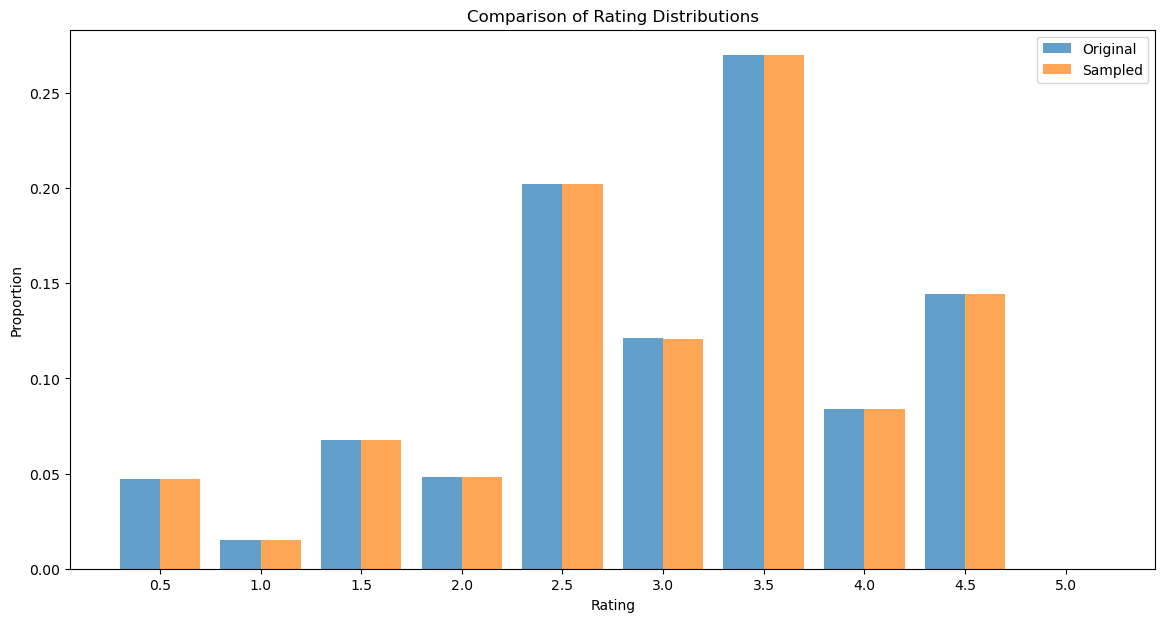

In [8]:
# Define your bins
bins = np.arange(0.5, 6.0, 0.5)

# Calculate bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Define width of each bar
bar_width = 0.2

# Plot histograms
plt.figure(figsize=(14, 7))
plt.bar(bin_centers - bar_width/2, ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Original', align='center')
plt.bar(bin_centers + bar_width/2, strat_sampled_ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Sampled', align='center')

plt.title('Comparison of Rating Distributions')
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.xticks(bin_centers, labels=[f"{bin:.1f}" for bin in bins[:-1]])  # Set x-tick labels to match bin centers
plt.legend()
plt.show()

In [9]:
strat_sampled_ratings_df

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user,rating_category
11800835,128365,1037,0.5,2009-10-19 10:10:37,3.104895,False,"[0.5, 1.0)"
3192182,34770,27316,0.5,2006-06-10 09:14:33,1.329146,False,"[0.5, 1.0)"
10041143,108700,307,0.5,2010-05-12 21:26:12,3.729651,False,"[0.5, 1.0)"
14911364,162680,73929,0.5,2015-11-22 18:22:29,3.505618,False,"[0.5, 1.0)"
13024846,141941,4308,0.5,2006-06-10 05:21:47,2.987685,False,"[0.5, 1.0)"
...,...,...,...,...,...,...,...
2596165,28184,2912,5.0,2000-11-21 00:08:40,3.588011,True,"[5.0, 5.5)"
2174721,23629,1185,5.0,1997-03-13 18:00:11,3.734463,True,"[5.0, 5.5)"
23363519,254448,49272,5.0,2016-08-08 15:59:55,3.819149,True,"[5.0, 5.5)"
19688576,214494,541,5.0,2005-04-05 14:26:59,3.395652,True,"[5.0, 5.5)"


Now we we want to add the movie title to the ratings dataset.

In [10]:
# Convert 'movieId' to string in both DataFrames
strat_sampled_ratings_df['movieId'] = strat_sampled_ratings_df['movieId'].astype(str)
movies_df['movieId'] = movies_df['movieId'].astype(str)

In [11]:
# Joining the DataFrames on 'movieId'
strat_sampled_ratings_df = pd.merge(strat_sampled_ratings_df, movies_df, on='movieId', how='left')
strat_sampled_ratings_df.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user,rating_category,id_x,imdbId,tmdbId,...,release_date,runtime,title,vote_average,vote_count,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
0,128365,1037,0.5,2009-10-19 10:10:37,3.104895,False,"[0.5, 1.0)",10163,104692,10163,...,1992-03-05,108.0,The Lawnmower Man,5.4,198.0,"[Jeff Fahey, Pierce Brosnan, Jenny Wright, Mar...","[dream, chimp, manipulation, botanist, virtual...","[Horror, Thriller, Science Fiction]","[New Line Cinema, Allied Vision]","[United Kingdom, Japan, United States of America]"
1,34770,27316,0.5,2006-06-10 09:14:33,1.329146,False,"[0.5, 1.0)",33253,235154,33253,...,1999-11-19,118.0,6ixtynin9,7.0,18.0,"[Lalita Panyopas, Sirisin Siripornsmathikul, P...","[airport, drug dealer, buddhist, mistaken iden...","[Comedy, Crime, Thriller]","[The Film Factory, Five Stars Production Company]",[Thailand]
2,108700,307,0.5,2010-05-12 21:26:12,3.729651,False,"[0.5, 1.0)",108,108394,108,...,1993-01-10,98.0,Three Colors: Blue,7.7,311.0,"[Juliette Binoche, Benoît Régent, Florence Per...","[paris, composer, pain, loss of husband, to co...","[Drama, Music, Mystery]","[France 3 Cinéma, CED Productions]","[France, Poland]"
3,162680,73929,0.5,2015-11-22 18:22:29,3.505618,False,"[0.5, 1.0)",22894,1038686,22894,...,2010-01-21,100.0,Legion,5.2,643.0,"[Paul Bettany, Dennis Quaid, Kevin Durand, Kat...","[angel, diner, religion, apocalypse, demon, de...",[Horror],[Bold Films],[United States of America]
4,141941,4308,0.5,2006-06-10 05:21:47,2.987685,False,"[0.5, 1.0)",824,203009,824,...,2001-03-09,127.0,Moulin Rouge!,7.4,1348.0,"[Nicole Kidman, Ewan McGregor, John Leguizamo,...","[duke, musical, writer's block, music, termina...","[Drama, Music, Romance]","[Bazmark Films, Twentieth Century Fox Film Cor...","[Australia, United States of America]"


In [12]:
# Keep only the necessary columns
strat_sampled_ratings_df = strat_sampled_ratings_df[['userId', 'movieId', 'rating', 'timestamp', 'title', 'genre_extracted', 'overview']]

# Rename the 'title' column to 'movie_title'
strat_sampled_ratings_df.rename(columns={'title': 'movie_title'}, inplace=True)

In [13]:
strat_sampled_ratings_df

,userId,movieId,rating,timestamp,movie_title,genre_extracted,overview
0,128365,1037,0.5,2009-10-19 10:10:37,The Lawnmower Man,"[Horror, Thriller, Science Fiction]",A simple man is turned into a genius through t...
1,34770,27316,0.5,2006-06-10 09:14:33,6ixtynin9,"[Comedy, Crime, Thriller]","A woman, fired from a financial coorporation d..."
2,108700,307,0.5,2010-05-12 21:26:12,Three Colors: Blue,"[Drama, Music, Mystery]",A woman struggles to find a way to live her li...
3,162680,73929,0.5,2015-11-22 18:22:29,Legion,[Horror],"When God loses faith in humankind, he sends hi..."
4,141941,4308,0.5,2006-06-10 05:21:47,Moulin Rouge!,"[Drama, Music, Romance]",A celebration of love and creative inspiration...
...,...,...,...,...,...,...,...
99996,28184,2912,5.0,2000-11-21 00:08:40,The Limey,"[Action, Crime, Drama, Mystery, Thriller]","The Limey follows Wilson (Terence Stamp), a to..."
99997,23629,1185,5.0,1997-03-13 18:00:11,My Left Foot: The Story of Christy Brown,[Drama],"In this true story told through flashbacks, Ch..."
99998,254448,49272,5.0,2016-08-08 15:59:55,Casino Royale,"[Adventure, Action, Thriller]","Le Chiffre, a banker to the world's terrorists..."
99999,214494,541,5.0,2005-04-05 14:26:59,Blade Runner,"[Science Fiction, Drama, Thriller]",In the smog-choked dystopian Los Angeles of 20...


In [14]:
# Drop missing values
strat_sampled_ratings_df.dropna(inplace=True)

In [ ]:
# Save the downsampled dataset to a pickle file
#strat_sampled_ratings_df.to_pickle('data/df_ratings_100k.pkl')

### Adjust Datasets for TFRS Requirements

#### Ratings Dataset

In [17]:
# Convert 'movieId' column in strat_sampled_ratings_df to 'Int64'
strat_sampled_ratings_df['movieId'] = strat_sampled_ratings_df['movieId'].astype('Int64')

# Convert 'movieId' and 'rating' column in ratings_df to 'object'
strat_sampled_ratings_df['movieId'] = strat_sampled_ratings_df['movieId'].astype(str)
strat_sampled_ratings_df['rating'] = strat_sampled_ratings_df['rating'].astype(str)


In [19]:
# Merge ratings_df and movies_df
ratings_df = strat_sampled_ratings_df

In [20]:
ratings_df.head()

,userId,movieId,rating,timestamp,movie_title,genre_extracted,overview
0,128365,1037,0.5,2009-10-19 10:10:37,The Lawnmower Man,"[Horror, Thriller, Science Fiction]",A simple man is turned into a genius through t...
1,34770,27316,0.5,2006-06-10 09:14:33,6ixtynin9,"[Comedy, Crime, Thriller]","A woman, fired from a financial coorporation d..."
2,108700,307,0.5,2010-05-12 21:26:12,Three Colors: Blue,"[Drama, Music, Mystery]",A woman struggles to find a way to live her li...
3,162680,73929,0.5,2015-11-22 18:22:29,Legion,[Horror],"When God loses faith in humankind, he sends hi..."
4,141941,4308,0.5,2006-06-10 05:21:47,Moulin Rouge!,"[Drama, Music, Romance]",A celebration of love and creative inspiration...


In [21]:
movies_df = movies_df[['movieId', 'title']]
movies_df.rename(columns={'title':'movie_title'}, inplace=True)
movies_df.head()

,movieId,movie_title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [22]:
import tensorflow as tf

# Convert 'rating' column in ratings_df to 'float'
ratings_df['rating'] = ratings_df['rating'].astype(float)

# Convert 'userId' column in ratings_df to 'str'
ratings_df['userId'] = ratings_df['userId'].astype(str)

# Create TensorFlow Datasets from ratings_df and movies_df
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'movie_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['movie_title']]))

# Map ratings Dataset
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["movie_title"])

In [23]:
# display the first few entries of the movies dataset
for x in movies.take(5).as_numpy_iterator():
    print(x)

b'Toy Story'
b'Jumanji'
b'Grumpier Old Men'
b'Waiting to Exhale'
b'Father of the Bride Part II'


2024-05-09 18:37:55.630664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
# display the first few entries of the ratings dataset
for x in ratings.take(5).as_numpy_iterator():
    print(x)

{'movie_title': b'The Lawnmower Man', 'userId': b'128365', 'rating': 0.5}
{'movie_title': b'6ixtynin9', 'userId': b'34770', 'rating': 0.5}
{'movie_title': b'Three Colors: Blue', 'userId': b'108700', 'rating': 0.5}
{'movie_title': b'Legion', 'userId': b'162680', 'rating': 0.5}
{'movie_title': b'Moulin Rouge!', 'userId': b'141941', 'rating': 0.5}


2024-05-09 18:37:57.187694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 99220


In [44]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

2024-05-09 18:46:20.709985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Unique Movies: 36265
Unique users: 55373


2024-05-09 18:46:22.042510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [49]:
class MovieModel(tf.keras.Model):
    def __init__(self):
        super(MovieModel, self).__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.rating = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

    def call(self, inputs):
        # Access inputs by keys instead of unpacking
        user_id = inputs['userId']
        movie_title = inputs['movie_title']

        user_embedding = self.user_model(user_id)
        movie_embedding = self.movie_model(movie_title)

        return self.rating(tf.concat([user_embedding, movie_embedding], axis=1))

# Adjust model compilation and training:
model = MovieModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1), loss=tf.keras.losses.MeanSquaredError())

# Ensure the training data is in the correct format:
# Assuming 'train' is a tf.data.Dataset and it yields a dictionary with keys 'userId', 'movie_title', and 'rating'
model.fit(train.batch(512), epochs=5)


Epoch 1/5


ValueError: None values not supported.

In [48]:
# Example to create training data:
train = tf.data.Dataset.from_tensor_slices(features).batch(512)

# Print a batch to check format:
for batch in train.take(1):
    print(batch)

NameError: name 'features' is not defined

In [47]:
# Train the model
model.fit(train.batch(512), epochs=5)

Epoch 1/5


/Users/maltehaupt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:1295: UserWarning: Layer 'movie_model_4' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''too many values to unpack (expected 2)''
  warnings.warn(
/Users/maltehaupt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'movie_model_4', however the layer does not have a `build()` method implemented and it looks like it h

ValueError: Exception encountered when calling MovieModel.call().

[1mtoo many values to unpack (expected 2)[0m

Arguments received by MovieModel.call():
  • inputs={'movie_title': 'tf.Tensor(shape=(None,), dtype=string)', 'userId': 'tf.Tensor(shape=(None,), dtype=string)', 'rating': 'tf.Tensor(shape=(None,), dtype=float32)'}